In [24]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt

% matplotlib inline

## How many images we have in train dataset

In [2]:
!ls data/train | wc -l
!ls data/train_masks/ | wc -l

5088
5088


## Training filenames looks like

In [3]:
!ls data/train/ | grep c_01.jpg

00087a6bd4dc_01.jpg
0ee135a3cccc_01.jpg
11fcda0a9e1c_01.jpg
2267f4aa0d2c_01.jpg
344ece157efc_01.jpg
3f8d611822bc_01.jpg
430f0cb5666c_01.jpg
4bea0766c14c_01.jpg
4f1f065d78ac_01.jpg
5588758ee21c_01.jpg
8d5423cb763c_01.jpg
b1a27da4f01c_01.jpg
d8e1c401ac3c_01.jpg


In [17]:
import os
from glob import glob

INPUT_PATH = './data'
DATA_PATH = INPUT_PATH
TRAIN_DATA = os.path.join(DATA_PATH, 'train')
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, 'train_masks')
TEST_DATA = os.path.join(DATA_PATH, 'test')
TRAIN_MASKS_CSV_FILEPATH = os.path.join(DATA_PATH, 'train_masks.csv')
METADATA_CSV_FILEPATH = os.path.join(DATA_PATH, 'metadata.csv')

TRAIN_MASKS_CSV = pd.read_csv(TRAIN_MASKS_CSV_FILEPATH)
METADATA_CSV = pd.read_csv(METADATA_CSV_FILEPATH)

In [18]:
train_files = glob(os.path.join(TRAIN_DATA, '*.jpg'))
train_ids = [s[len(TRAIN_DATA)+1:-4] for s in train_files]

In [19]:
def get_filename(image_id, image_type):
    check_dir = False
    if 'Train' == image_type:
        ext = 'jpg'
        data_path = TRAIN_DATA
        suffix = ''
    elif 'Train_mask' in image_type:
        ext = 'gif'
        data_path = TRAIN_MASKS_DATA
        suffix = '_mask'
    elif 'Test' in image_type:
        ext = 'jpg'
        data_path = TEST_DATA
        suffix = ''
    else:
        raise Exception('Image type {} is not recognized'.format(image_type))
    
    if check_dir and not os.path_exists(data_path):
        os.makedirs(data_path)
        
    return os.path.join(data_path, '{}{}.{}'.format(image_id, suffix, ext))

In [22]:
import cv2
from PIL import Image

def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else: 
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, 'Failed to read image: {}, {}'.format(image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, 'False to read image: {}, {}. Error message: {}'.format(
            image_id, image_type, e)
        
    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()), )
    
    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), ('Open image is not an ndarray. ' 
        'Image id/type: {}, {}.'.format(image_id, image_type))
        
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()

## Display a single car with its mask

Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type:       uint8


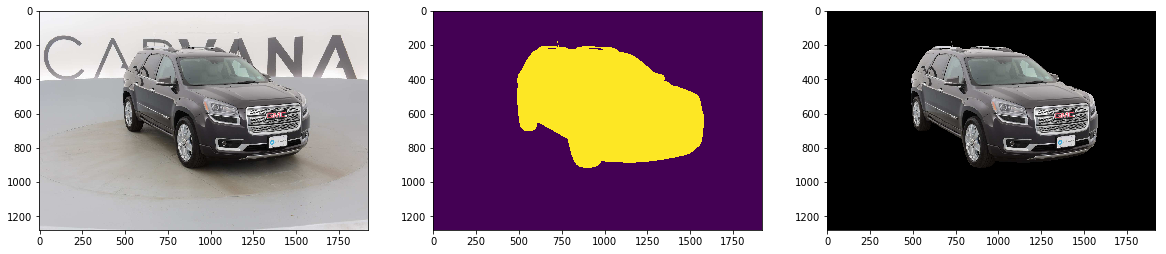

In [25]:
image_id = train_ids[0]

plt.figure(figsize=(20, 20))
img = get_image_data(image_id, 'Train')
mask = get_image_data(image_id, 'Train_mask')
img_masked = cv2.bitwise_and(img, img, mask=mask)

print('Image shape: {} | image type: {} | mask shape: {} | mask type: \
      {}'.format(img.shape, img.dtype, mask.shape, mask.dtype))

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(img_masked)

## Display 500 random cars from train dataset

In [31]:
_train_ids = list(train_ids)
np.random.shuffle(_train_ids)
_train_ids = _train_ids[:500]
tile_size = (256, 256)
n = 8

m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image = np.zeros((m * (tile_size[0] + 2), n * (tile_size[1] + 2), 3), 
                         dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i * (tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j * (tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_id = _train_ids[counter]; counter+=1
        img = get_image_data(image_id, 'Train')
        img = cv2.resize(img, dsize=tile_size)
        img = cv2.putText(img, image_id, (5, img.shape[0] - 5), 
                         cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 
                         thickness=2)
        complete_image[ys:ye, xs:xe, :] = img[:,:,:]
        if counter == len(_train_ids):
            break

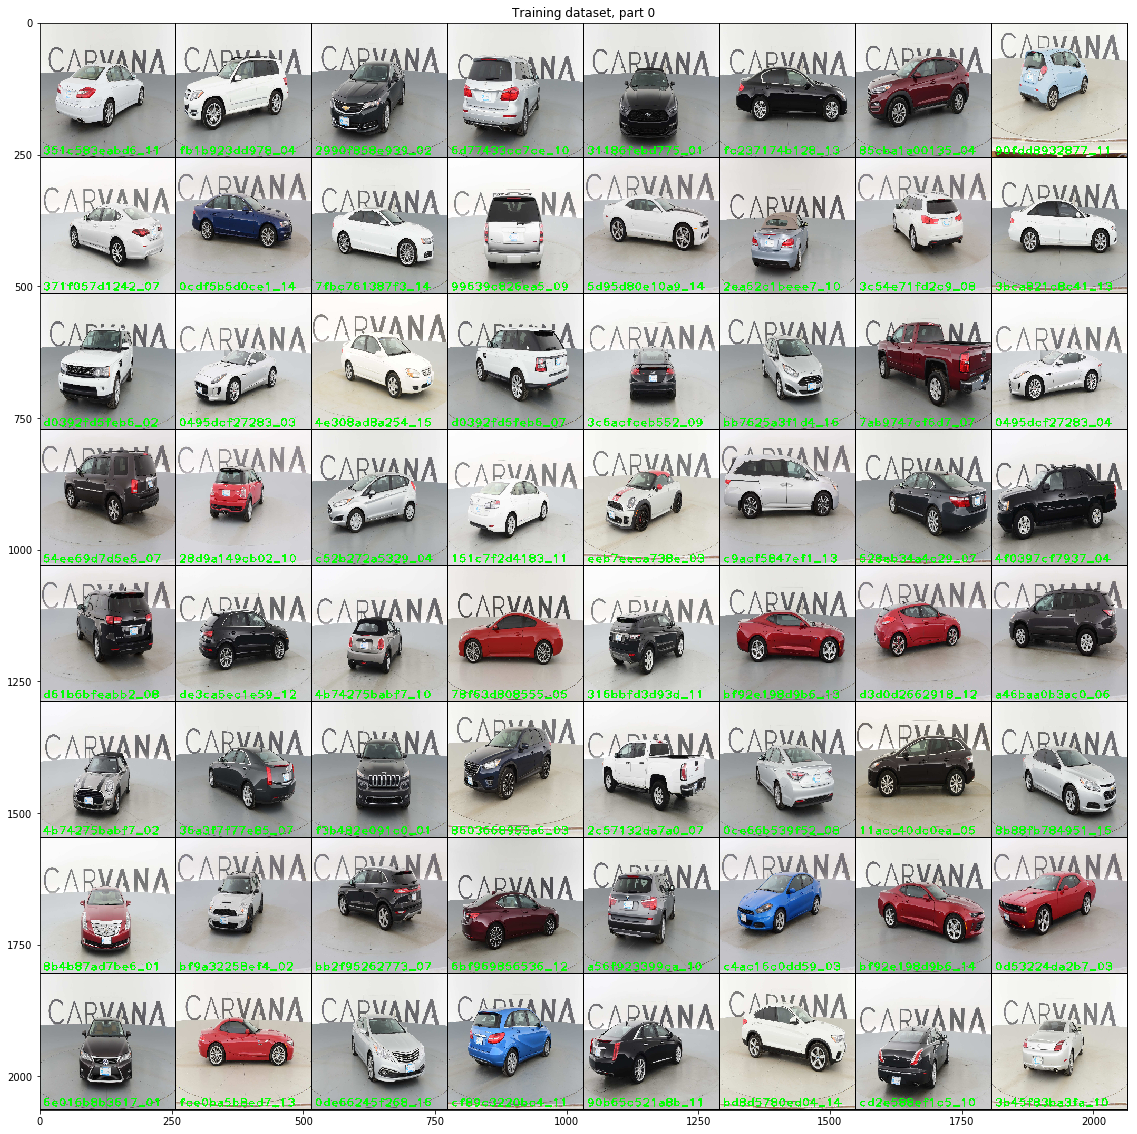

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


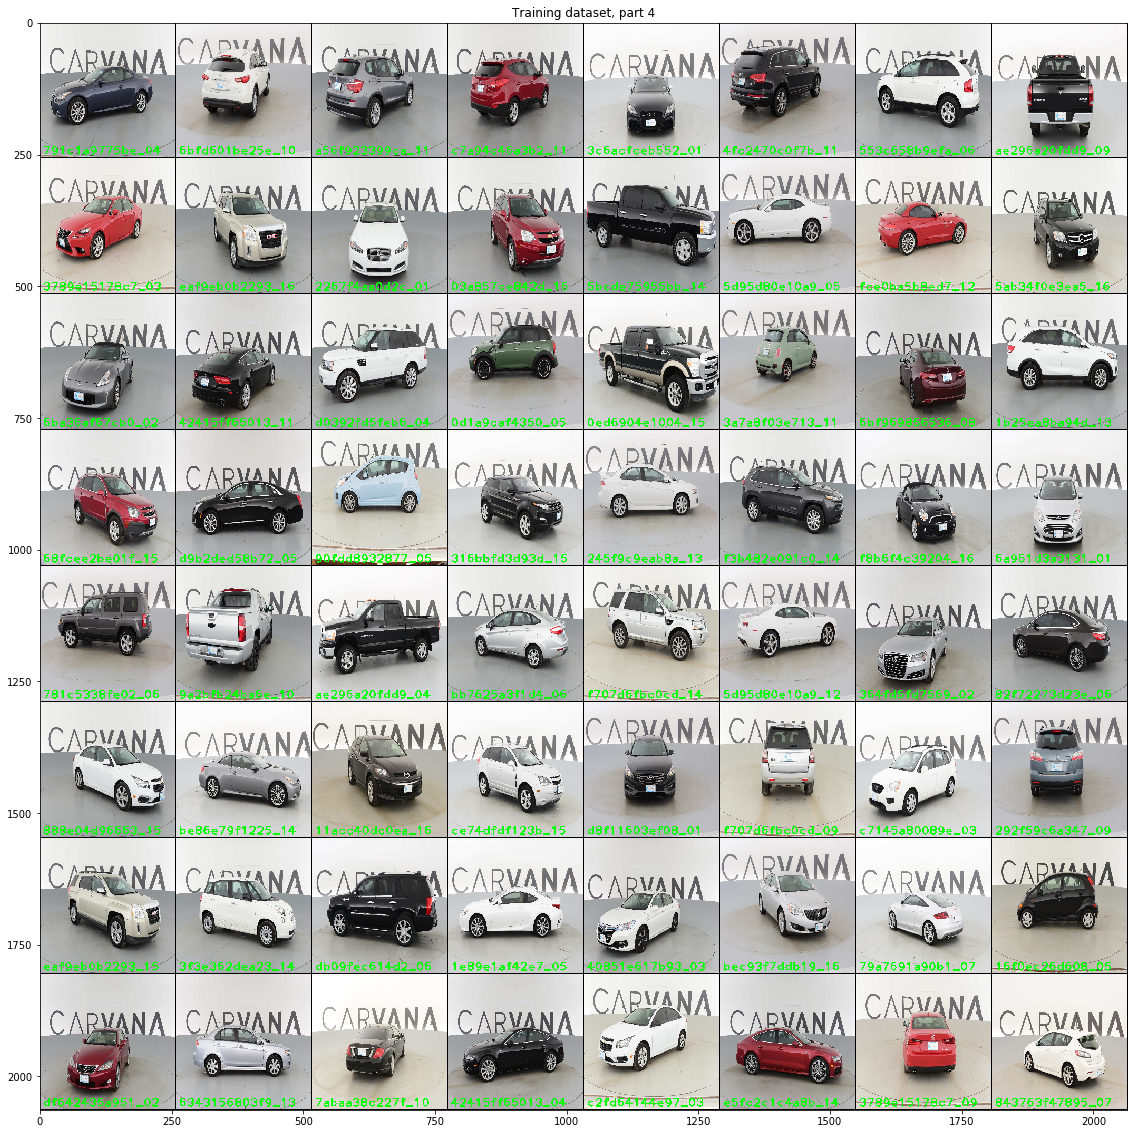

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [32]:
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i * (tile_size[0] + 2) * k
    ye = min((i + 1) * (tile_size[0] + 2) * k, complete_image.shape[0])
    plt.imshow(complete_image[ys:ye,:,:])
    plt.title('Training dataset, part {}'.format(i))

## How many different car in all datasets

In [33]:
len(METADATA_CSV['id'].unique()), len(METADATA_CSV['id'])

(6572, 6572)

## How many different cars in train dataset

In [40]:
TRAIN_MASKS_CSV['id'] = TRAIN_MASKS_CSV['img'].apply(lambda x: x[:-7])
len(TRAIN_MASKS_CSV['id'].unique()), len(TRAIN_MASKS_CSV['id'].unique()) * 16

(318, 5088)

In [41]:
all_318_car_ids = TRAIN_MASKS_CSV['id'].unique()

## Display all 318 cars at 03 angle from train dataset 

In [49]:
all_318_cars_image_ids = [_id + '_03' for _id in all_318_car_ids]

In [53]:
_train_ids = list(all_318_cars_image_ids)
tile_size = (256, 256)
n = 8
m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image = np.zeros((m * (tile_size[0] + 2), n * (tile_size[1] + 2), 3), 
                         dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i * (tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j * (tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_id = _train_ids[counter]
        counter += 1
        img = get_image_data(image_id, 'Train')
        img = cv2.resize(img, dsize=tile_size)
        img = cv2.putText(img, image_id, (5, img.shape[0] - 5), 
                         cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 
                         thickness=2)
        complete_image[ys:ye, xs:xe, :] = img[:, :, :]
    if counter == len(_train_ids):
        break

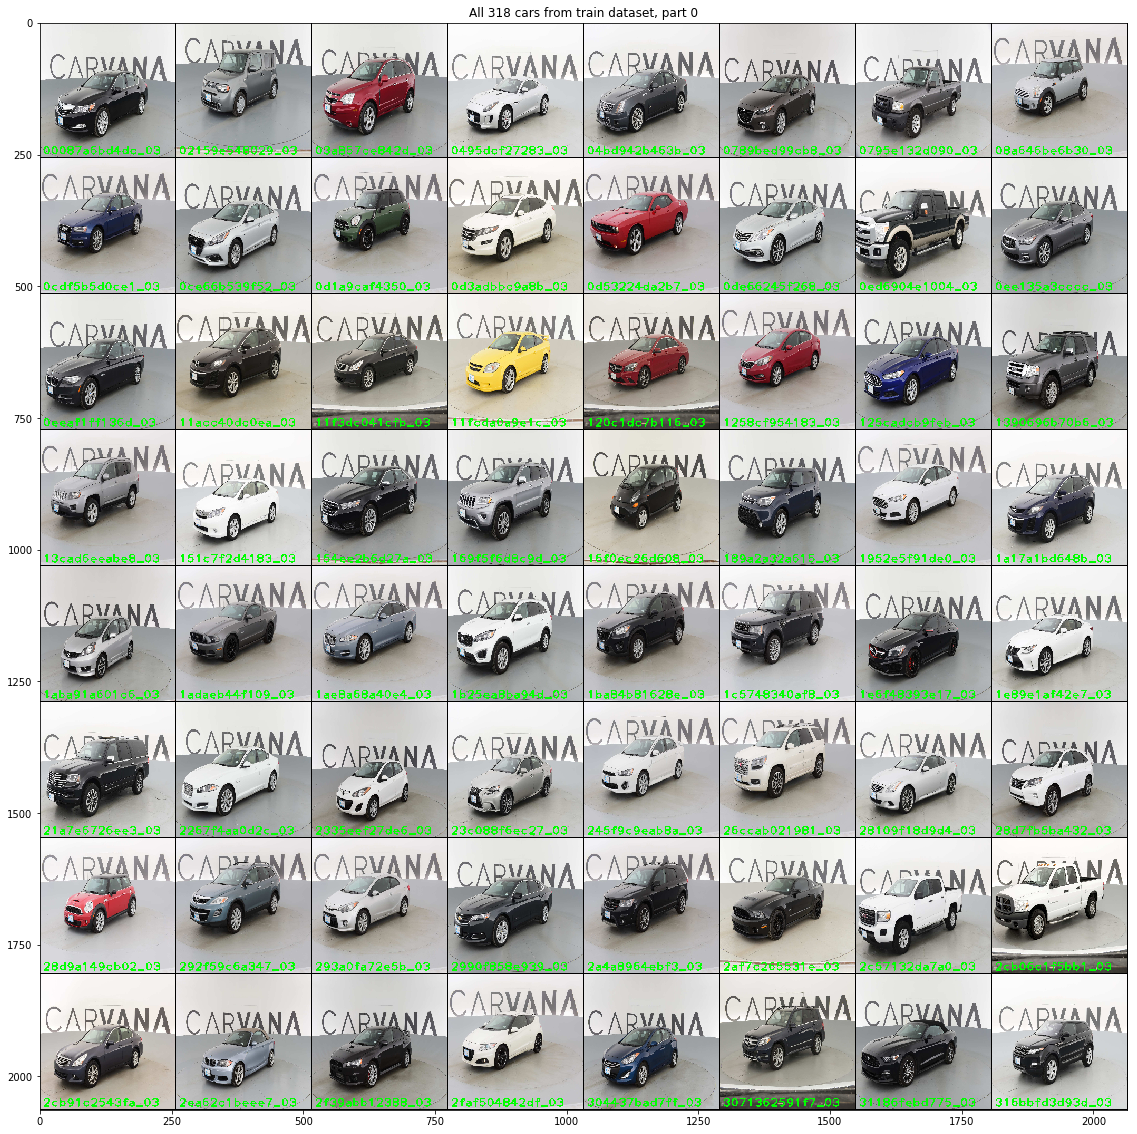

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


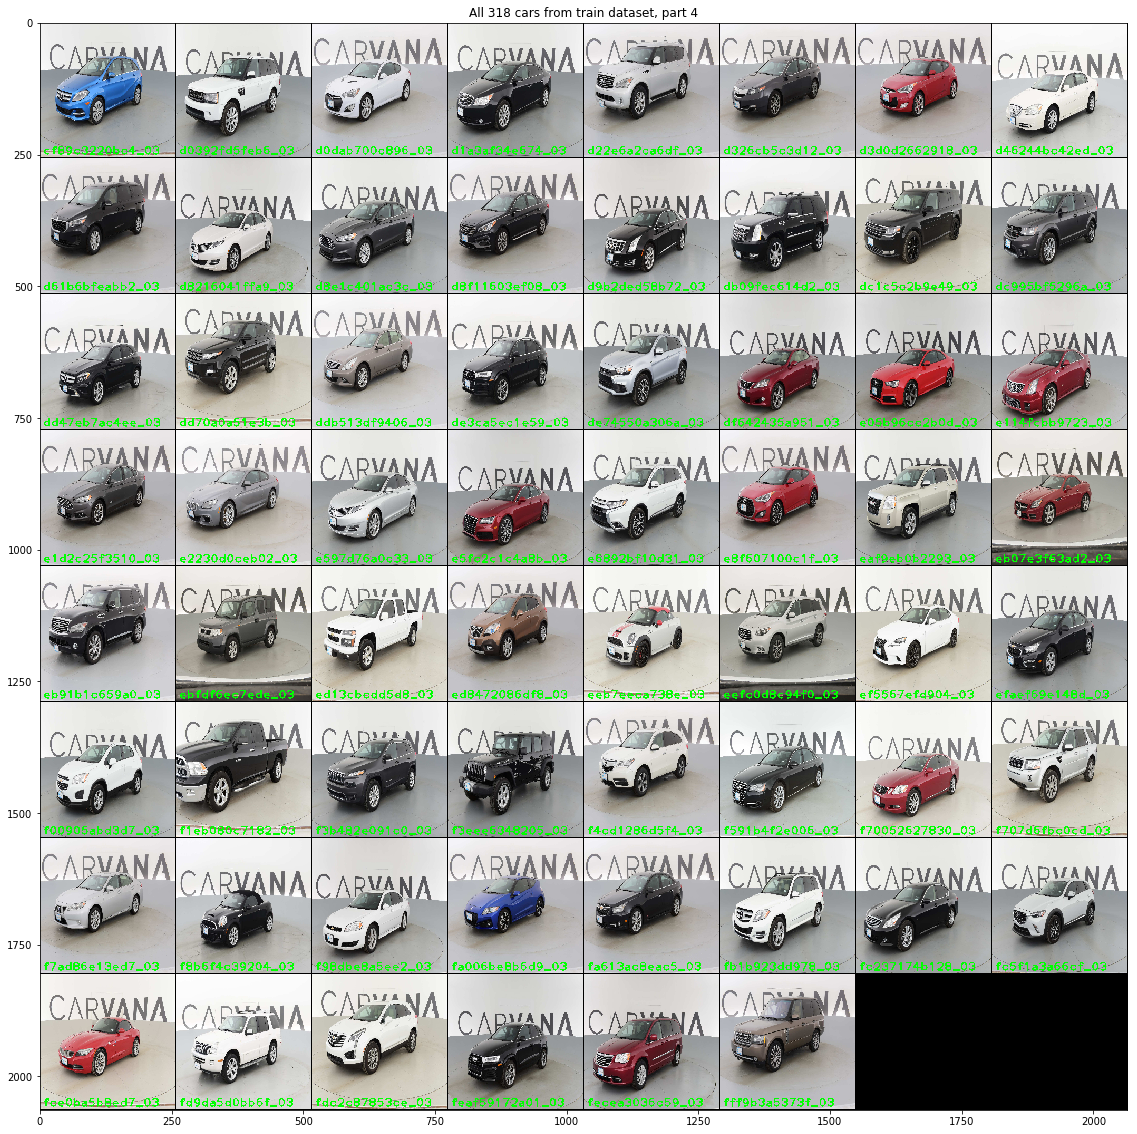

In [57]:
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i * (tile_size[0] + 2) * k
    ye = min((i + 1) * (tile_size[0] + 2) * k, complete_image.shape[0])
    plt.imshow(complete_image[ys:ye,:,:])
    plt.title('All 318 cars from train dataset, part {}'.format(i))